In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from scipy.stats import zscore , mstats

In [2]:
# 1. Load the temperature dataset
temperature_data = pd.read_csv("temperaturedata.csv")

In [3]:
# 2. Convert 'date' column to datetime format (if applicable)
if 'date' in temperature_data.columns:
    temperature_data['date'] = pd.to_datetime(temperature_data['date'])

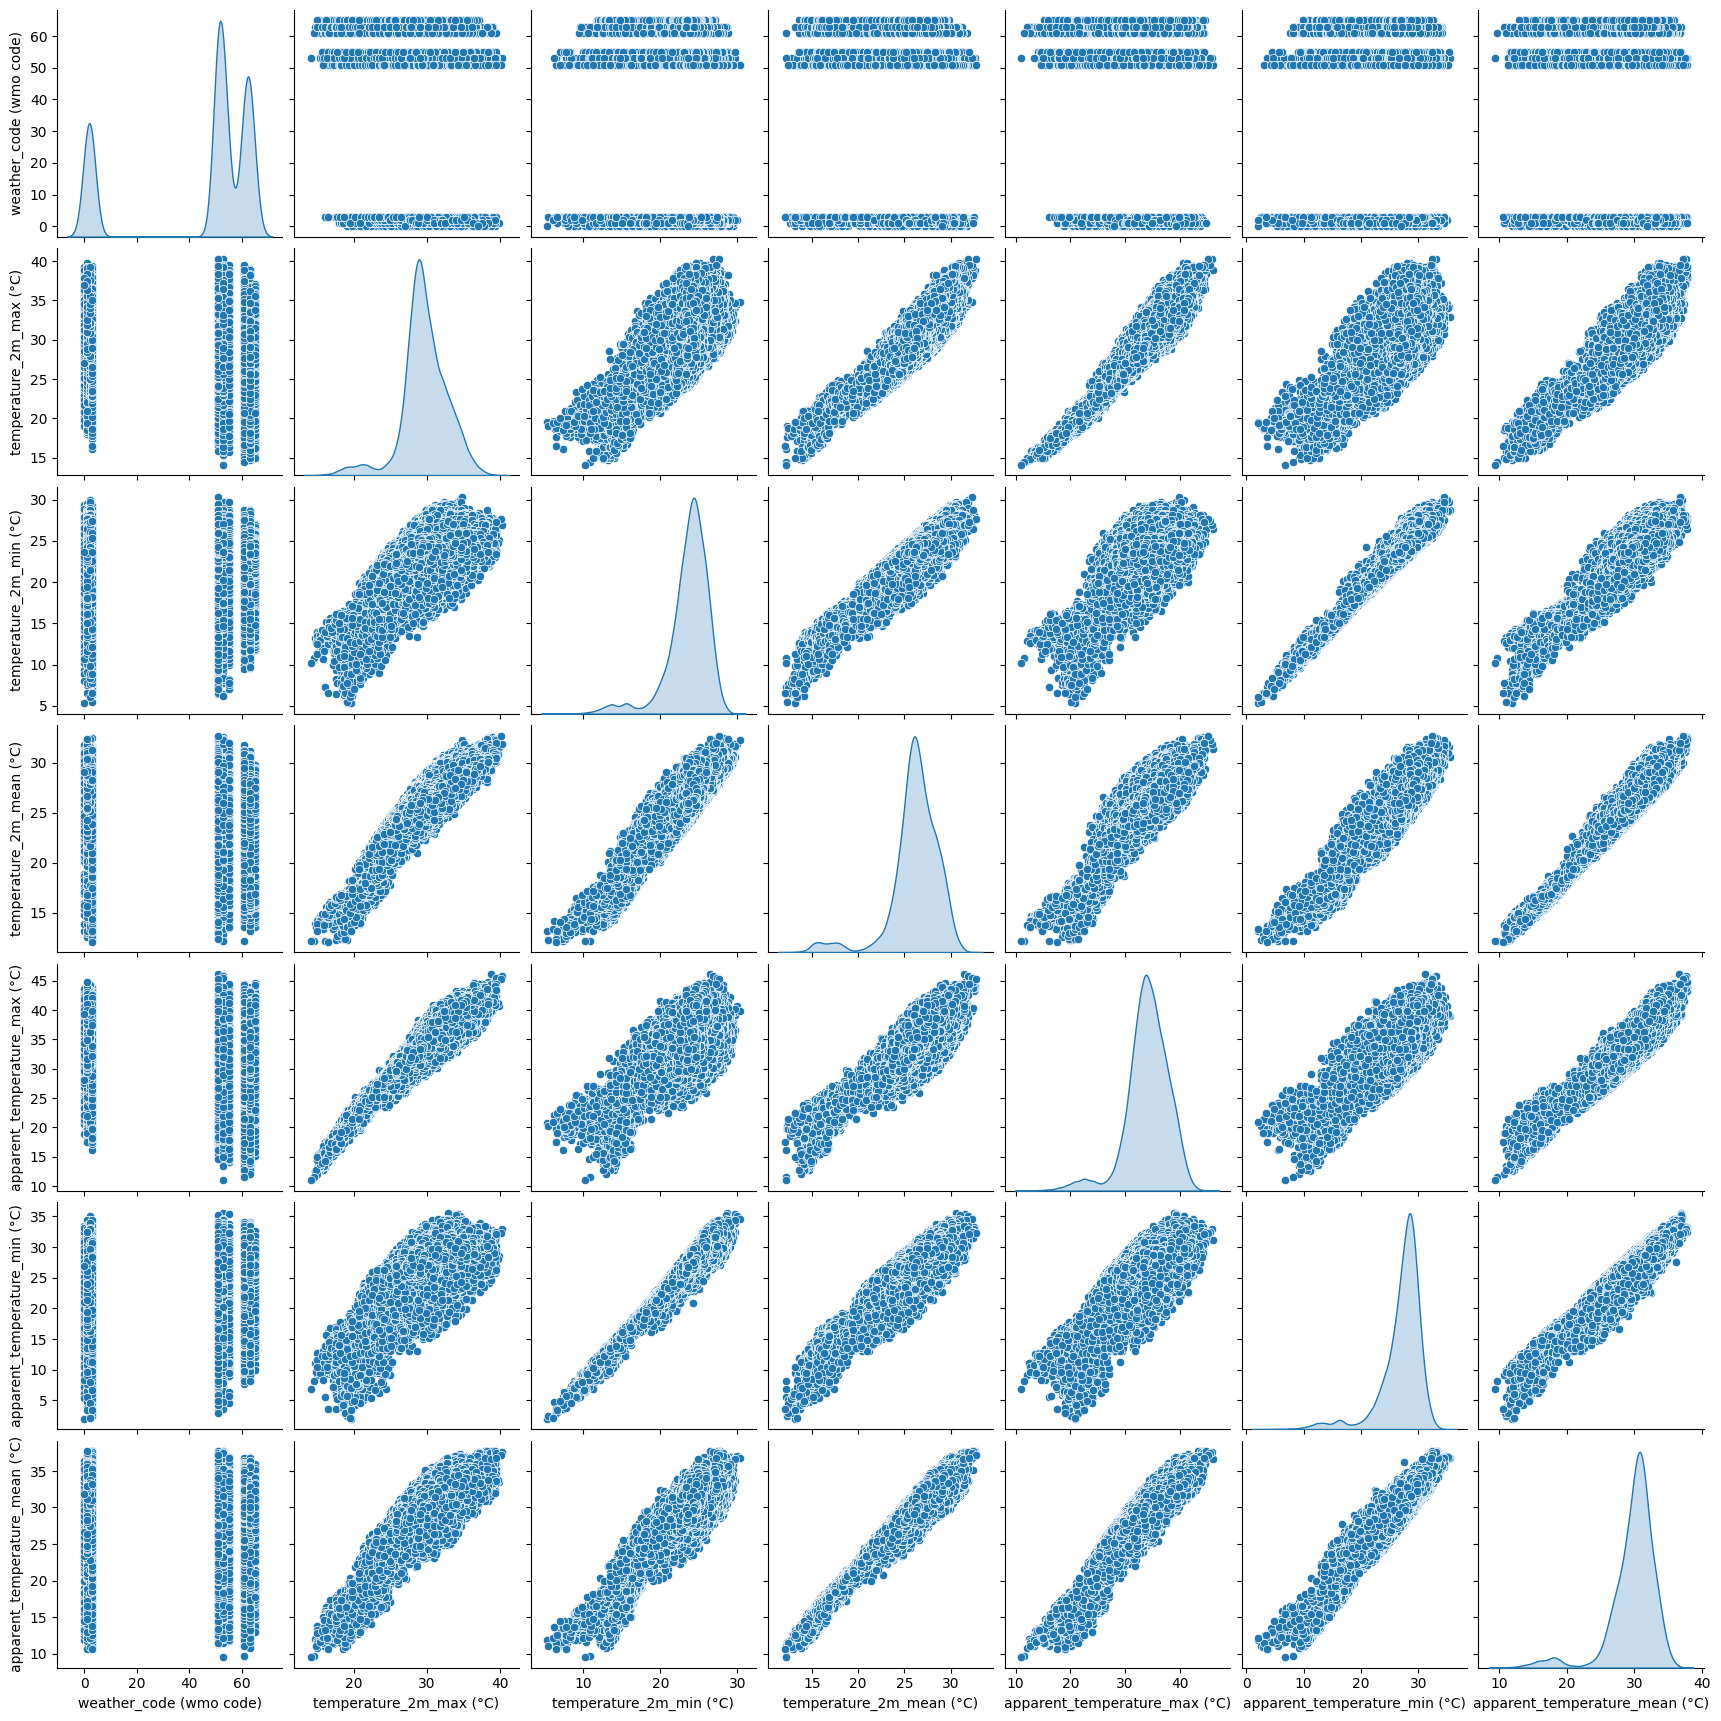

In [11]:
# 4. Visualize the dataset distribution
sns.pairplot(temperature_data, diag_kind='kde', height=2.5)
plt.show()

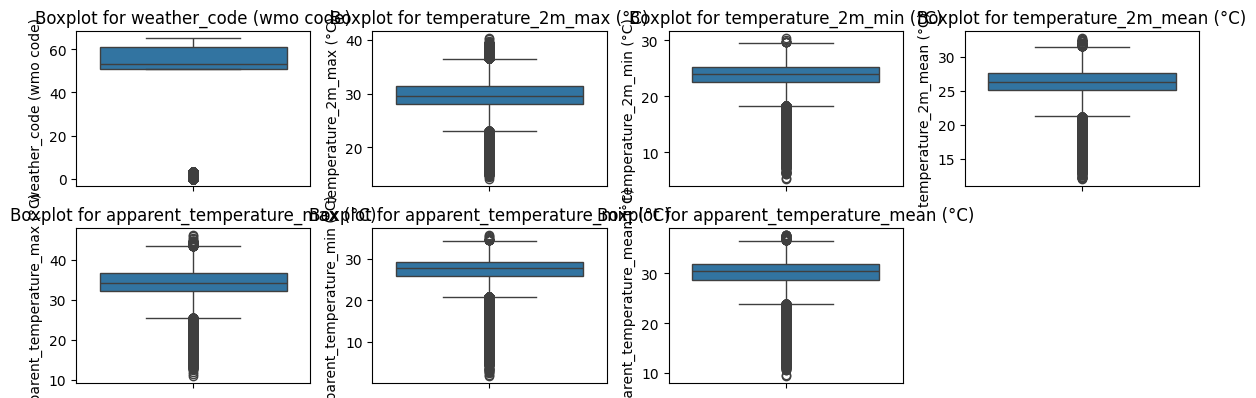

In [12]:
# 5. Checking for outliers using boxplots
numerical_features = temperature_data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=temperature_data[feature])
    plt.title(f'Boxplot for {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Check for missing values in the dataset
missing_values = temperature_data.isnull().sum()

# Print the number of missing values for each column
print("Missing Values in Each Column:")
print(missing_values)

# Total missing values in the entire dataset
total_missing = missing_values.sum()
print(f"\nTotal Missing Values in the Dataset: {total_missing}")


Missing Values in Each Column:
district                          0
month                             0
date                              0
weather_code (wmo code)           0
temperature_2m_max (°C)           0
temperature_2m_min (°C)           0
temperature_2m_mean (°C)          0
apparent_temperature_max (°C)     0
apparent_temperature_min (°C)     0
apparent_temperature_mean (°C)    0
dtype: int64

Total Missing Values in the Dataset: 0


In [15]:
temperature_data.dropna(subset=['district'], inplace=True)

# Verify that missing values are removed
print("\nMissing Values After Cleaning:")
print(temperature_data.isnull().sum())

# Save the cleaned dataset (optional)
temperature_data.to_csv("temperaturedata.csv", index=False)

print("\nCleaned dataset saved back as 'temperaturedata.csv'.")


Missing Values After Cleaning:
district                          0
month                             0
date                              0
weather_code (wmo code)           0
temperature_2m_max (°C)           0
temperature_2m_min (°C)           0
temperature_2m_mean (°C)          0
apparent_temperature_max (°C)     0
apparent_temperature_min (°C)     0
apparent_temperature_mean (°C)    0
dtype: int64

Cleaned dataset saved back as 'temperaturedata.csv'.


In [4]:
# Initialize LabelEncoders
label_encoder_month = LabelEncoder()
label_encoder_district = LabelEncoder()

# Fit and transform encoding
temperature_data['Month_encoded'] = label_encoder_month.fit_transform(temperature_data['month'])
temperature_data['Districts_encoded'] = label_encoder_district.fit_transform(temperature_data['district'])

# Save the encoders for later use
joblib.dump(label_encoder_month, "Temp_encoder_month.pkl")
joblib.dump(label_encoder_district, "Temp_encoder_district.pkl")

['Temp_encoder_district.pkl']

In [5]:
# . Check for outliers using z-scores(rechecking the outliers-if we need any column without remove then we do not add it into feature)
features = ['Month_encoded','Districts_encoded','apparent_temperature_mean (°C)']
z_scores = np.abs(zscore(temperature_data[features]))
outlier_indices = np.where(z_scores > 3)  # Threshold for identifying outliers
print(f"\nNumber of outliers detected: {len(outlier_indices[0])}")

# Get the rows that correspond to the outliers
outliers = temperature_data.iloc[outlier_indices[0]]

# Display the outliers
print(outliers)



Number of outliers detected: 4674
            district    month       date  weather_code (wmo code)  \
26365   Nuwara Eliya     June 2010-01-01                        2   
26366   Nuwara Eliya     June 2010-01-02                        3   
26367   Nuwara Eliya     June 2010-01-03                       51   
26368   Nuwara Eliya     June 2010-01-04                       53   
26369   Nuwara Eliya     June 2010-01-05                        3   
...              ...      ...        ...                      ...   
113279       Badulla  January 2017-01-08                        3   
113284       Badulla  January 2017-01-13                        3   
113642       Badulla  January 2018-01-06                       51   
113643       Badulla  January 2018-01-07                       51   
113654       Badulla  January 2018-01-18                        3   

        temperature_2m_max (°C)  temperature_2m_min (°C)  \
26365                      20.9                     14.4   
26366           

In [ ]:
# 6. Handle outliers by clipping to the 5th and 95th percentiles
for feature in numerical_features:
    lower_limit = temperature_data[feature].quantile(0.05)
    upper_limit = temperature_data[feature].quantile(0.95)
    temperature_data[feature] = np.clip(temperature_data[feature], lower_limit, upper_limit)

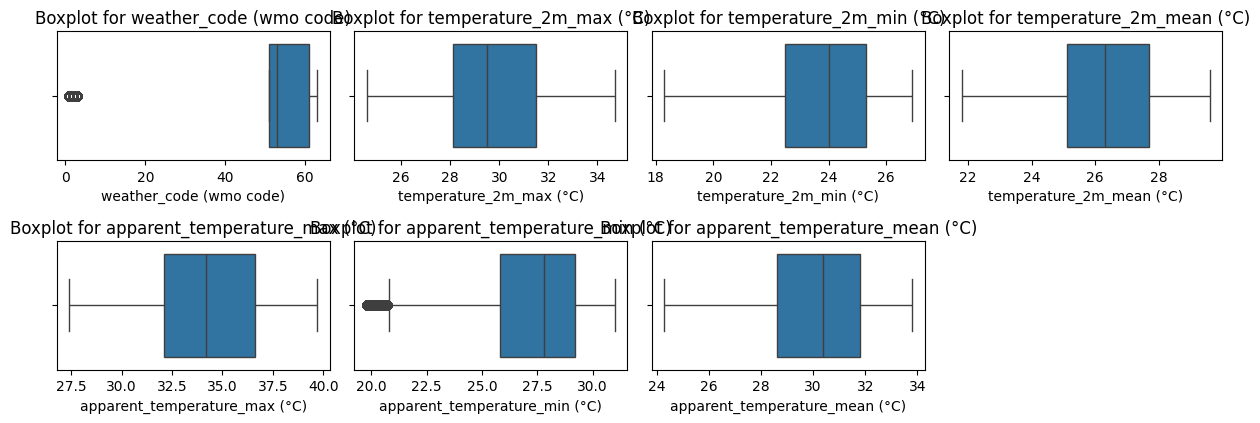

In [37]:
#Checking for outliers using boxplots
numerical_features = temperature_data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=temperature_data[feature])
    plt.title(f'Boxplot for {feature}')
plt.tight_layout()
plt.show()

In [7]:
# 7. Prepare features and target labels
# Assuming 'temperature' is the target column and others are features
X = temperature_data[['Districts_encoded', 'Month_encoded']]
y = temperature_data['temperature_2m_mean (°C)']


In [8]:
# 8. Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'temperature_scaler.pkl')

['temperature_scaler.pkl']

In [9]:
# 9. Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)  # 70% training, 30% testing/validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)  # 20% validation, 80% testing


In [10]:
# 10. Build the prediction model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

f:\Softwares\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping with increased patience
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=20,           # Increase patience to 20 epochs
    min_delta=0.001,       # Set a small change threshold to consider improvement
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 55.6027 - mae: 4.5670 - val_loss: 3.7584 - val_mae: 1.5256
Epoch 2/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 10.0521 - mae: 2.5309 - val_loss: 3.8838 - val_mae: 1.5481
Epoch 3/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 8.8829 - mae: 2.3801 - val_loss: 3.7203 - val_mae: 1.5196
Epoch 4/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 8.0021 - mae: 2.2611 - val_loss: 3.7551 - val_mae: 1.5277
Epoch 5/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 7.2802 - mae: 2.1563 - val_loss: 3.7431 - val_mae: 1.5274
Epoch 6/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 6.8029 - mae: 2.0857 - val_loss: 3.6843 - val_mae: 1.5125
Epoch 7/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 6.2932 - mae: 2.0024 - val_loss: 3.6104 - val_mae: 1.5100
Epoch 8/100
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 5.8287 - mae: 1.9248 - val_loss: 3.4138 - val_mae: 1.4624
Epoch 9/100
5767/5767 

In [43]:
# 12. Save the trained model and preprocessing artifacts
model.save('temperature_prediction_model.h5')
print("Temperature prediction model saved successfully.")

Temperature prediction model saved successfully.


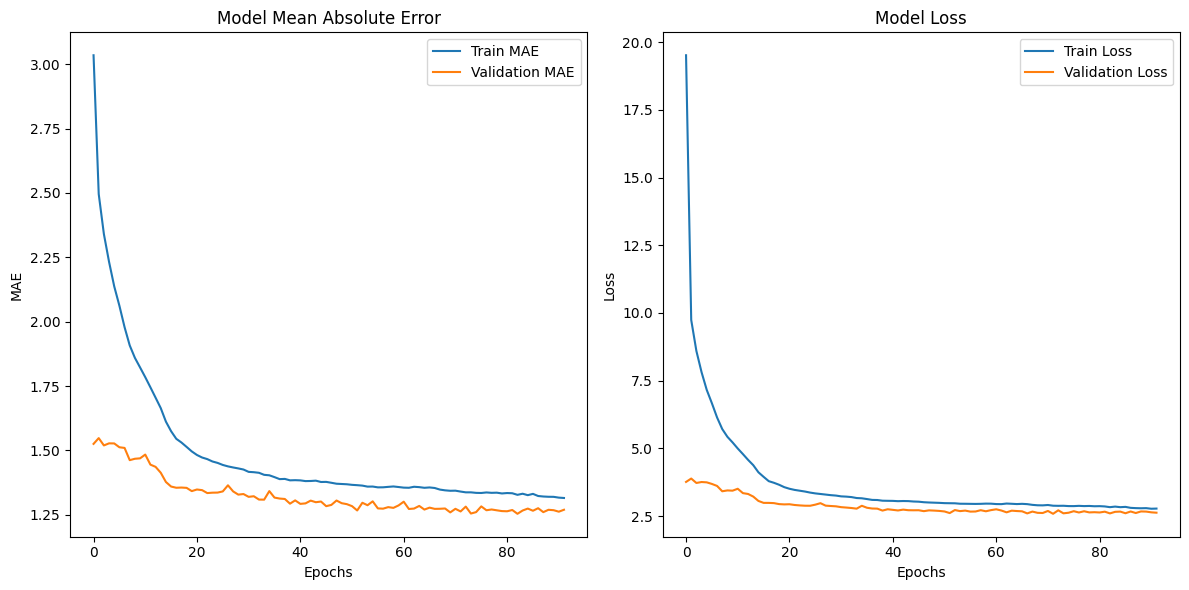

In [44]:
# 13. Visualize training and validation metrics
plt.figure(figsize=(12, 6))

# Plot MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load the trained model
model = load_model("temperature_prediction_model.h5", custom_objects={"mse": MeanSquaredError()})

# Load the saved encoderss
label_encoder_month = joblib.load("Temp_encoder_month.pkl")
label_encoder_district = joblib.load("Temp_encoder_district.pkl")

# Example test data
new_data = {
    "month": "December",
    "district": "Ampara"
}

# Encode categorical values
Month_encoded = label_encoder_month.transform([new_data["month"]])[0]
Districts_encoded = label_encoder_district.transform([new_data["district"]])[0]

# Prepare feature array
features = np.array([[Month_encoded, Districts_encoded]])

# ✅ Correct the shape (model expects (None, 2), so reshape to (1, 2))
features_reshaped = features.reshape(1, 2)

# Make prediction
predicted_Temperature = model.predict(features_reshaped)

print(f"Predicted Temperature (C): {predicted_Temperature[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Predicted Temperature (C): 31.359085083007812


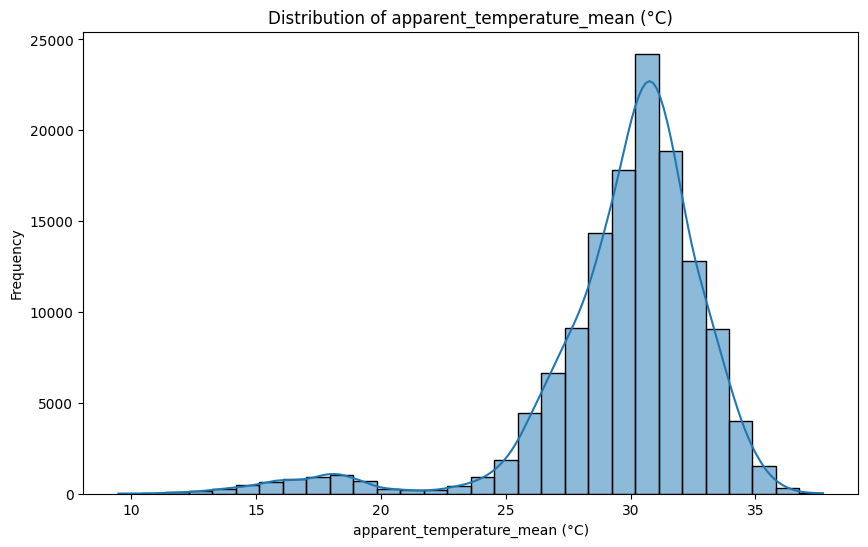

In [11]:
# Visualize the distribution of the target variable (Storage %)
plt.figure(figsize=(10, 6))
sns.histplot(temperature_data['apparent_temperature_mean (°C)'], kde=True, bins=30)
plt.title('Distribution of apparent_temperature_mean (°C)')
plt.xlabel('apparent_temperature_mean (°C)')
plt.ylabel('Frequency')
plt.show()

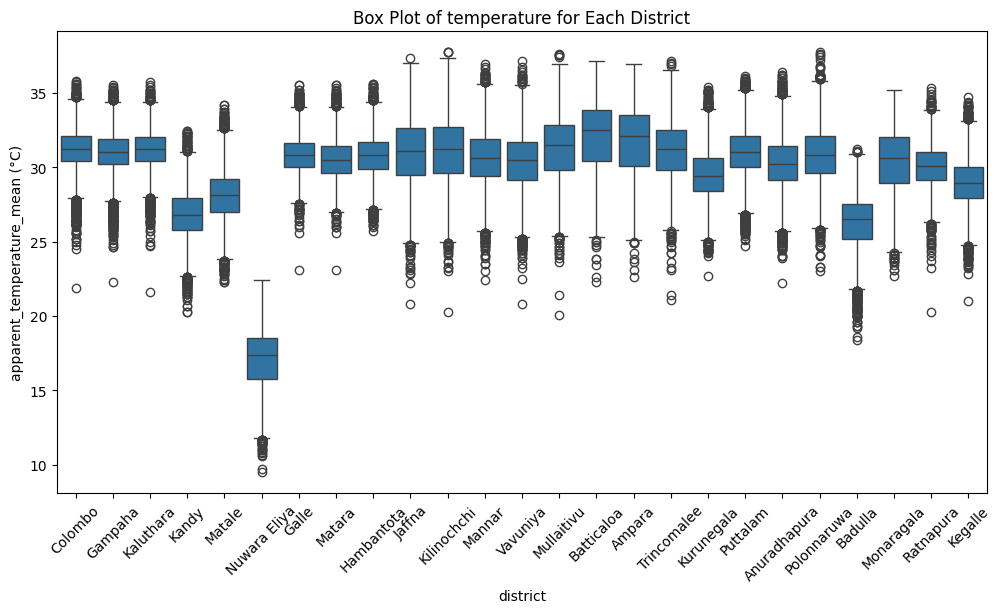

In [12]:
plt.figure(figsize=(12, 6))  # Increase figure size if needed
sns.boxplot(x='district', y='apparent_temperature_mean (°C)', data=temperature_data)
plt.title('Box Plot of temperature for Each District')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

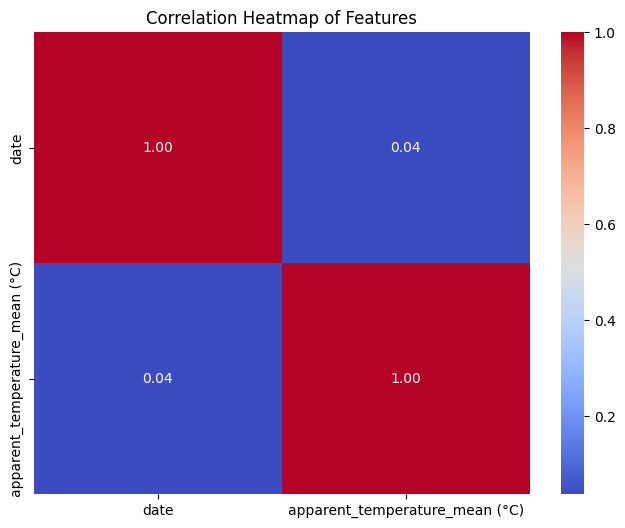

In [14]:
corr = temperature_data[['date', 'apparent_temperature_mean (°C)']].corr()  # Remove 'Range'
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()